In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
import csv
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.data import BiasedRandomWalk
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

2022-05-05 15:25:33.075657: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset

In [2]:
# Create graph for csv file with edge weights (we loose some edges as this data would requirea a multidigraph)
def parse_ckn_csv(fname):
    g = nx.Graph()
    fields = ['from', 'to', 'type', 'reliability']
    with open(fname, newline='') as csvfile:
        reader = csv.DictReader(csvfile, fieldnames=fields, dialect=csv.excel_tab, restkey='rest', )
        for row in reader:
            g.add_edge(row['from'], row['to'], type=row['type'], reliability=row['reliability'])
#            if row['type'] == 'binding':
#                g.add_edge(row['to'], row['from'], type=row['type'], reliability=row['reliability'])
    return g

In [3]:
g = parse_ckn_csv("../data/LKN_ath_v3B_2016-08-30.txt")

In [4]:
# we lost 1500 edges bcs of using a simple graph
g.number_of_edges()

68503

In [5]:
# Check for errors in the graph
print(sorted(g.nodes)[:20])
print(sorted(g.nodes)[-20:])
isolated = list(nx.isolates(g))
print(f"isolated nodes={isolated}")
#g.remove_nodes_from(isolated)

['6K1', '6K2', 'AT1G01010', 'AT1G01020', 'AT1G01030', 'AT1G01040', 'AT1G01050', 'AT1G01060', 'AT1G01070', 'AT1G01080', 'AT1G01090', 'AT1G01100', 'AT1G01110', 'AT1G01120', 'AT1G01130', 'AT1G01140', 'AT1G01150', 'AT1G01160', 'AT1G01170', 'AT1G01180']
['MIR858', 'MIR859', 'MIR860', 'MIR861', 'MIR862', 'MIR863', 'MIR864', 'MIR865', 'MIR866', 'MIR867', 'MIR868', 'MIR869', 'MIR870', 'NIa-Pro', 'NIb', 'P1', 'P3', 'P3N-PIPO', 'R-gene', 'VPg']
isolated nodes=[]


In [6]:
list(g.edges(data=True))[:10]

[('6K1', '6K2', {'type': 'binding', 'reliability': 'r1'}),
 ('6K1', 'CI', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', 'CI', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', 'NIa-Pro', {'type': 'binding', 'reliability': 'r1'}),
 ('6K2', 'VPg', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'AT1G30380', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'AT5G03160', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'CI', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'CP', {'type': 'binding', 'reliability': 'r1'}),
 ('CI', 'HC-Pro', {'type': 'binding', 'reliability': 'r1'})]

In [7]:
# Some general characteristics of the graph
print(f'nodes={g.number_of_nodes()}, edges={g.number_of_edges()}, density: {nx.density(g):.4f}')

nodes=20011, edges=68503, density: 0.0003


Graph is sparse with a high number of weakly connected components and has a very low density (range 0-1).

In [8]:
# # List of weakly connected components
# [len(c) for c in sorted(nx.weakly_connected_components(g), key=len, reverse=True)][:25]

In [9]:
# from collections import Counter
# from pprint import pprint
# c_sizes = Counter()
# for c in nx.weakly_connected_components(g):
#     c_sizes[len(c)] += 1
# pprint(sorted(c_sizes.items()))

In [10]:
# Check whether the graph is connected
nx.is_connected(g)

False

In [11]:
# identify the largest connected component and create a corresponding subgraph
max_c = max(nx.connected_components(g))
print(f"biggest component size={len(max_c)}")
g = nx.subgraph(g, max_c)

# Some general characteristics of the subgraph
print(f"subgraph nodes={g.number_of_nodes()}, subgraph edges={g.number_of_edges()}, density: {nx.density(g):.4f}")

biggest component size=17550
subgraph nodes=17550, subgraph edges=66031, density: 0.0004


There is only one large connected component the rest are negligible so we will consider only the largest component.

# Link prediction

In [12]:
# Create graph within the StellarGraph library
G = StellarGraph.from_networkx(g)

In [13]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 17550, Edges: 66031

 Node types:
  default: [17550]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [66031]
        Weights: all 1 (default)
        Features: none


## Construct train-test splits of the graph data

### Test Graph (graph_test)

We create the test graph and test set of positive/negative edge examples from the full graph. 
* graph_test = reduced graph obtained by removing the test set of edges from the full graph. [same as source]
* examples_test = set of positive/negative edge examples (node pairs) [np_array]
* labels_test = labels of pos and neg edges (1, 0) [np_array]

In [14]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p of all positive links, and same number of negative links, from full graph, and obtain the
# reduced graph graph_test with the sampled positive links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.5, method="global"
)

print(graph_test.info())

** Sampled 33015 positive and 33015 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 17550, Edges: 33016

 Node types:
  default: [17550]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [33016]
        Weights: all 1 (default)
        Features: none


In [15]:
len(examples_test)

66030

In [16]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

### Train Graph

We use EdgeSplitter on Test Graph and perform  train/test split to create:
* Train Graph
* Training set of edge examples
* Model selection set of edge examples

In [17]:
# Same as above to produce a training subset from the Test Graph (graph_test)
edge_splitter_train = EdgeSplitter(graph_test)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 3301 positive and 3301 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 17550, Edges: 29715

 Node types:
  default: [17550]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [29715]
        Weights: all 1 (default)
        Features: none


In [18]:
len(examples_train)

4951

Summary of the different splits that have been created

In [19]:
# Overview of splits created
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,4951,Train Graph,Test Graph,Train the Link Classifier
Model Selection,1651,Train Graph,Test Graph,Select the best Link Classifier model
Test set,66030,Test Graph,Full Graph,Evaluate the best Link Classifier


## Node embeddings

Use Node2vec to generate the node embeddings with random walks, which try to maintain the node similarity from the graph (proximity in the embedding space). Output are node pairs, which are used to train a Word2Vec model.

### Node2Vec 

In [20]:
# parameters
p = 1.0
q = 1.0
dimensions = 128
num_walks = 50
walk_length = 40
window_size = 5
epochs = 1
workers = int(multiprocessing.cpu_count() / 2)

In [21]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")
    
    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=epochs,
    )
    
    def get_embedding(u):
        return model.wv[u]
    
    return get_embedding

In [22]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")
# lahk tudi kar tukaj poženeš classifier

Number of random walks for 'Train Graph': 877500


## Train and evaluate the link prediction model

To use Word2Vec model for link prediction we need to perform these steps:
1. Calculate the edge embeddings for positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes
2. Train classifier to predict a binary label
3. Evaluate the performance of the link classifier for each binary operator on training data with node embeddings calculated on the Train Graph and select the best classifier
4. The best classifier is used to calculate scores on the test data with node embeddings calcluated on the Test Graph.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1. Edge embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]

# 2. Training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
                                                          
# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score, predicted = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score, predicted

def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features) ## verjetnosti za napovedi 

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column]), predicted

We use 4 different binary operators that produce link embeddings that have equal dimensionality to the input node embeddings. 

In [24]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [25]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")
      
pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,"(0.747062121025352, [[0.39817708203833635, 0.6..."
operator_l1,"(0.6825740633126127, [[0.5268957582660603, 0.4..."
operator_l2,"(0.685532486895475, [[0.5045823472115719, 0.49..."
operator_avg,"(0.6746511819019612, [[0.2730298373852569, 0.7..."


### Evaluate the best model using the test set

We now use the test set of embeddings and calculate a final evaluation score. 

In [26]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 877500


In [27]:
test_score, predicted = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_hadamard': 0.6865614065483936


### Create df of edges with R values and predictions

In [28]:
# Edges test examples is set of positive/negative edge examples (node pairs) that were removed from the full graph. [np_array]
examples_test

array([['AT4G00870', 'AT2G35310'],
       ['AT5G61850', 'AT5G38410'],
       ['AT4G34210', 'AT1G55000'],
       ...,
       ['AT2G27650', 'AT5G46030'],
       ['AT2G42530', 'MIR5650'],
       ['AT4G12390', 'AT2G25850']], dtype=object)

In [29]:
# Labels of pos and neg edges (1, 0) for test edges examples [np_array]
labels_test

array([1, 1, 1, ..., 0, 0, 0])

In [30]:
# Label predicitons for each edge test example
predicted

array([[6.85053209e-01, 3.14946791e-01],
       [2.28031943e-01, 7.71968057e-01],
       [9.59173300e-04, 9.99040827e-01],
       ...,
       [3.29811314e-01, 6.70188686e-01],
       [1.13141979e-01, 8.86858021e-01],
       [1.33035795e-01, 8.66964205e-01]])

In [52]:
# # Create df with the test data and predictions
# df_pred = pd.DataFrame(examples_test, columns=["from", "to"])
# df_pred["labels"] = labels_test
# df_pred[["pred_1", "pred_0"]] = pd.DataFrame(predicted, columns=["pred_1", "pred_0"])
# df_pred.drop(["pred_0"], axis=1, inplace=True)
# df_pred["R-value"] = np.nan
# df_pred

df_pred = pd.DataFrame(examples_test, columns=["from", "to"])
df_pred["labels"] = labels_test
df_pred[["pred_0", "pred_1"]] = pd.DataFrame(predicted)
# df_pred.drop(["pred_0"], axis=1, inplace=True)
df_pred["R-value"] = np.nan
df_pred

,from,to,labels,pred_0,pred_1,R-value
0,AT4G00870,AT2G35310,1,0.685053,0.314947,NaN
1,AT5G61850,AT5G38410,1,0.228032,0.771968,NaN
2,AT4G34210,AT1G55000,1,0.000959,0.999041,NaN
3,AT1G16170,AT2G07040,1,0.203536,0.796464,NaN
4,AT5G21920,AT4G16444,1,0.166337,0.833663,NaN
...,...,...,...,...,...,...
66025,AT1G12100,AT1G01820,0,0.237389,0.762611,NaN
66026,AT2G26030,AT2G26500,0,0.681331,0.318669,NaN
66027,AT2G27650,AT5G46030,0,0.329811,0.670189,NaN
66028,AT2G42530,MIR5650,0,0.113142,0.886858,NaN


In [53]:
df = pd.read_csv("../data/LKN_ath_v3B_2016-08-30.txt", 
                 names=["from", "to", "interaction", "R-value", "pis"], sep="\t", header=None)
df

,from,to,interaction,R-value,pis
0,6K1,6K2,binding,r1,NaN
1,6K1,CI,binding,r1,NaN
2,6K2,CI,binding,r1,NaN
3,6K2,NIa-Pro,binding,r1,NaN
4,6K2,VPg,binding,r1,NaN
...,...,...,...,...,...
70085,NIb,VPg,binding,r1,NaN
70086,P1,VPg,binding,r1,NaN
70087,R-gene,AT2G43790,activation,r5,PIS
70088,R-gene,AT3G45640,activation,r5,PIS


In [54]:
df["interaction"].value_counts()

binding       34758
unk_TF        24653
act_TF         5569
inh_ncRNA      2904
inh_TF         1685
synthesis       209
activation      180
inhibition      132
Name: interaction, dtype: int64

In [55]:
# test un uniqueness
a = set()
for i, row in df.iterrows():
    a.add((row["from"], row["to"], row["interaction"]))
print(len(a))
    

70090


In [56]:
# # Add R value to df_pred
# df_loop = df_pred.copy()
# for idx_pred, row_pred in df_loop.iterrows():
#     for idx_org, row_org in df.iterrows():
#         if list(row_org[["from", "to"]]) == list(row_pred[["from", "to"]]):
#             df_pred.loc[idx_pred, "R-value"] = row_org["R-value"]

In [57]:
# Create dictionary edge : R-value from original df
dict_org ={}

for row in df.itertuples(name=None):
    dict_org[row[1:3]] = row[4]

# Create tuple edges in df_pred
data_edges = list(zip(df_pred["from"], df_pred["to"]))

df_pred.insert(2, "edge_tuple", value=data_edges)

In [58]:
# Map R-values from original data to pozitive edges in df_pred
r_values = []
for rid, row in df_pred.iterrows():
    if g.has_edge(row["from"], row["to"]):
        r_values.append(g.edges[row["from"], row["to"]]["reliability"])
    else: 
        r_values.append(np.nan)
df_pred["R-value"] = r_values
df_pred

,from,to,edge_tuple,labels,pred_0,pred_1,R-value
0,AT4G00870,AT2G35310,"(AT4G00870, AT2G35310)",1,0.685053,0.314947,r4
1,AT5G61850,AT5G38410,"(AT5G61850, AT5G38410)",1,0.228032,0.771968,r1
2,AT4G34210,AT1G55000,"(AT4G34210, AT1G55000)",1,0.000959,0.999041,r1
3,AT1G16170,AT2G07040,"(AT1G16170, AT2G07040)",1,0.203536,0.796464,r2
4,AT5G21920,AT4G16444,"(AT5G21920, AT4G16444)",1,0.166337,0.833663,r2
...,...,...,...,...,...,...,...
66025,AT1G12100,AT1G01820,"(AT1G12100, AT1G01820)",0,0.237389,0.762611,NaN
66026,AT2G26030,AT2G26500,"(AT2G26030, AT2G26500)",0,0.681331,0.318669,NaN
66027,AT2G27650,AT5G46030,"(AT2G27650, AT5G46030)",0,0.329811,0.670189,NaN
66028,AT2G42530,MIR5650,"(AT2G42530, MIR5650)",0,0.113142,0.886858,NaN


In [59]:
# # Map R-values from original data to pozitive edges in df_pred
# df_loop = df_pred[df_pred.labels == 1].copy()

# # for key in dict_org:
# #     df_pred[df_pre.edge_tuple == key]["R-value"] = dict_org[key]

# ## Vid: problem da slučajno dela ssaj se index spremeni!
# for idx, row in df_loop.iterrows():
#     try:
#         df_pred.loc[idx, "R-value"] = dict_org[row.edge_tuple]
#     except KeyError:
#         df_pred.loc[idx, "R-value"] = np.nan

In [60]:
df_poz = df_pred[df_pred.labels == 1]
df_poz["R-value"].value_counts(dropna=False)

r2    16748
r1     9035
r4     5869
r3     1106
r5      257
Name: R-value, dtype: int64

In [61]:
df_poz["R-value"].value_counts(normalize=True)

r2    0.507285
r1    0.273663
r4    0.177768
r3    0.033500
r5    0.007784
Name: R-value, dtype: float64

In [62]:
df_poz

,from,to,edge_tuple,labels,pred_0,pred_1,R-value
0,AT4G00870,AT2G35310,"(AT4G00870, AT2G35310)",1,0.685053,0.314947,r4
1,AT5G61850,AT5G38410,"(AT5G61850, AT5G38410)",1,0.228032,0.771968,r1
2,AT4G34210,AT1G55000,"(AT4G34210, AT1G55000)",1,0.000959,0.999041,r1
3,AT1G16170,AT2G07040,"(AT1G16170, AT2G07040)",1,0.203536,0.796464,r2
4,AT5G21920,AT4G16444,"(AT5G21920, AT4G16444)",1,0.166337,0.833663,r2
...,...,...,...,...,...,...,...
33010,AT4G37680,AT2G38330,"(AT4G37680, AT2G38330)",1,0.151490,0.848510,r2
33011,AT4G17220,AT4G02720,"(AT4G17220, AT4G02720)",1,0.002287,0.997713,r2
33012,AT3G15030,AT1G60990,"(AT3G15030, AT1G60990)",1,0.679340,0.320660,r4
33013,AT5G63790,AT1G78070,"(AT5G63790, AT1G78070)",1,0.362757,0.637243,r4


In [63]:
# Check distribution of R-value among high predictions for label 1 (existing link).
df_poz.loc[df_poz["pred_1"] >= 0.90]["R-value"].value_counts(normalize=True)

r1    0.366693
r2    0.365973
r4    0.242494
r5    0.014328
r3    0.010512
Name: R-value, dtype: float64

### Graf korelacije R in predikcij 


In [64]:
# box graf; če naraščajo intervali (boxi) med Ri je kul, če ravno ni korelacije;

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
plot_data = df_poz.loc[:, ["R-value", "pred_1"]]
plot_data

,R-value,pred_1
0,r4,0.314947
1,r1,0.771968
2,r1,0.999041
3,r2,0.796464
4,r2,0.833663
...,...,...
33010,r2,0.848510
33011,r2,0.997713
33012,r4,0.320660
33013,r4,0.637243


<AxesSubplot:>

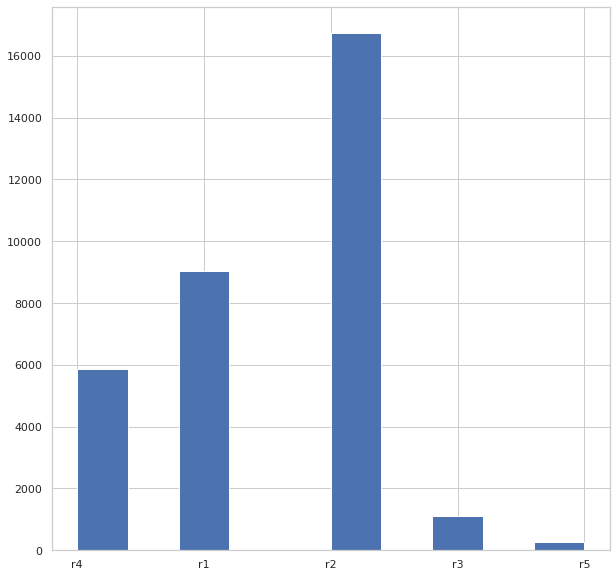

In [67]:
plot_data["R-value"].hist()

<AxesSubplot:>

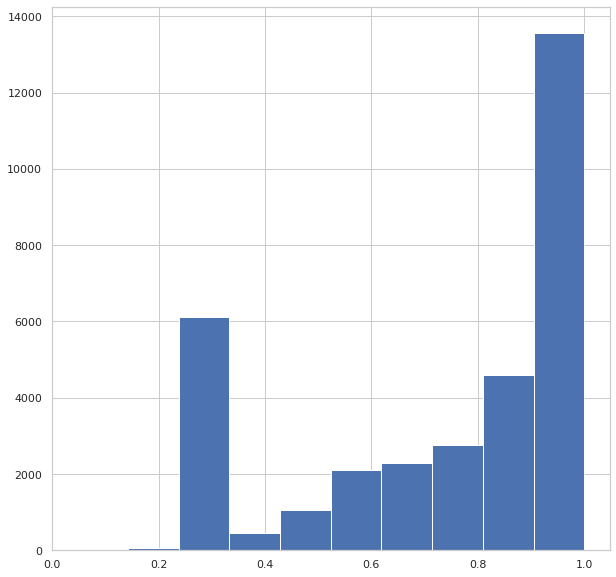

In [68]:
plot_data.pred_1.hist()

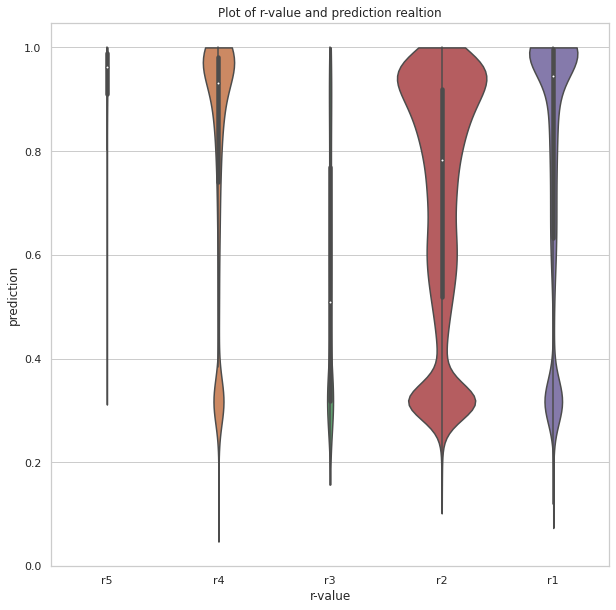

In [70]:
# plot with seaborn

sns.set(rc={'figure.figsize':(10, 10)})
sns.set_theme(style="whitegrid")
sns.violinplot(x="R-value", 
                   y="pred_1",
                   data=plot_data, 
                   order=["r5", "r4", "r3", "r2", "r1"], 
                   scale="count",
#                    inner="quartile",
#                    palette="Set2",
                   cut=0)

plt.xlabel("r-value")
plt.ylabel("prediction")
plt.title("Plot of r-value and prediction realtion")
plt.savefig("CKN_violinPlot_MPS_1_0.png")